# Custom dataset

To train a Lenet on a custom dataset, first download the images from: https://www.kaggle.com/c/dogs-vs-cats/data

In [208]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from Model import CNN
from Dataset import CatsAndDogsDataset
from tqdm import tqdm
import pandas as pd
import os

In [209]:
# if available, we set device to cuda in order to utilize GPU resources for training
device = "cpu" # ("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cpu


- Given the DB, first costruct a csv with data and labels

In [210]:
train_df = pd.DataFrame(columns=["img_name","label"])
train_df["img_name"] = os.listdir("../data/train/")
for idx, i in enumerate(os.listdir("../data/train/")):
    if "cat" in i:
        train_df["label"][idx] = 0
    if "dog" in i:
        train_df["label"][idx] = 1

train_df.to_csv (r'train_csv.csv', index = False, header=True)

In [227]:
#INSPECTION:

Annotations = pd.read_csv("train_csv.csv")
index = 0

img_id = Annotations.iloc[index, 0]
print("- Image ID: " + img_id)

y_label = Annotations.iloc[index, 1]
print(f"- Image Label: {y_label}")


- Image ID: dog.5658.jpg
- Image Label: 1


- then define a class specifying _init_ , _len_ , _getitem_

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
import torchvision
from PIL import Image
import torch

class CatsAndDogsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

- Ready to organize data in training and validation exploiinting the DataLoader

In [196]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((28,28)), #((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

#num_epochs = 10
#learning_rate = 0.00001
#train_CNN = False
batch_size = 32
shuffle = True
pin_memory = False #True
num_workers = 1

dataset = CatsAndDogsDataset("../data/train","train_csv.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5000])
train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

#model = CNN().to(device)

criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [207]:
#SOME PRINTS FOR INSPECTION:

# an example in the datatset: image and label
print(dataset[0][0].shape)
print(dataset[0][1])

print(f' Training {len(train_set)}, Validation {len(validation_set)}')
i=100
print(f' the element {i} has label {dataset[i][1]}')

print(f"Number of training batches: {len(train_loader)}") #20000/32 (|train_set|/batch_size)

torch.Size([3, 28, 28])
tensor(1.)
 Training 20000, Validation 5000
 the element 100 has label 0.0
Number of training batches: 625


In [ ]:
- The remaining as 

In [189]:
from d2l import torch as d2l
import torch
from torch import nn


class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 3, 28, 28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 1) , nn.Sigmoid())

In [190]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [191]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device= "cpu"): #d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Model parameter INITIALIZATION
    net.apply(init_weights)
    print('training on', device)
    net.to(device) # MOVE the net to the GPU (if available)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            #l = loss(y_hat, y)
            l = criterion(torch.squeeze(y_hat), y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(torch.squeeze(y_hat), y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 50.195, train acc 0.498, test acc 16.226
2806.8 examples/sec on cpu


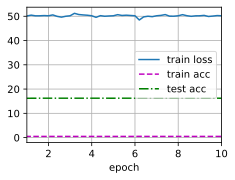

In [192]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_loader, validation_loader, num_epochs, lr)

Many other links: 
- https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895


# Exercise:

Sometimes the images are not remìnamed according to the label but grouped in proper folding like in thsi DB: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data. How you could adapt the code to deal with this data organization?